In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint

In [2]:
train_df = pd.read_csv("sign_lang_mnist/sign_mnist_train.csv")
test_df = pd.read_csv("sign_lang_mnist/sign_mnist_test.csv")

<Axes: title={'center': 'Test: Label Distribution'}, ylabel='Frequency'>

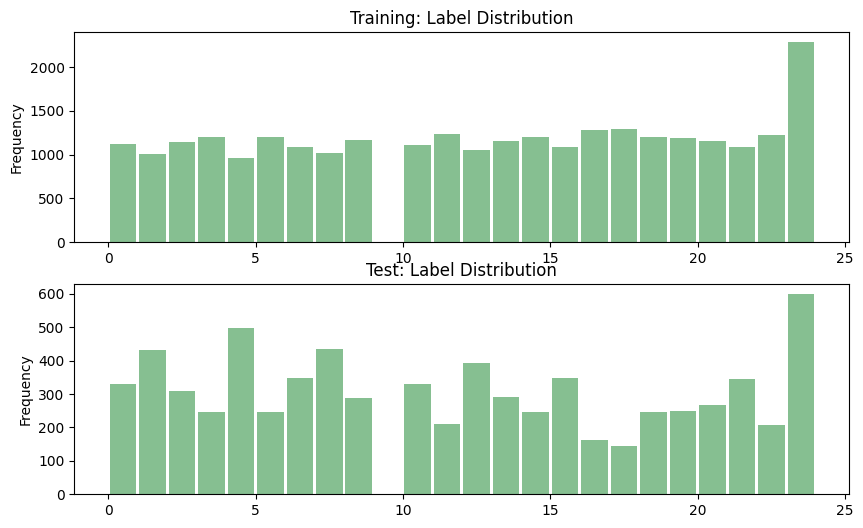

In [3]:
fig, axes = plt.subplots(2, figsize=(12, 10))

axes[0].set_title('Training: Label Distribution')
train_df['label'].plot(kind='hist', bins=24, ax=axes[0], grid=False, figsize=(10, 6), color='#86bf91', zorder=2, rwidth=0.9)

axes[1].set_title('Test: Label Distribution')
test_df['label'].plot(kind='hist', bins=24, ax=axes[1], grid=False, figsize=(10, 6), color='#86bf91', zorder=2, rwidth=0.9)

In [4]:
y_train = train_df['label']
y_test = test_df['label']

train_df.drop(columns=['label'], inplace=True)
test_df.drop(columns=['label'], inplace=True)

In [5]:
# Converting labels to OneHotEncodings
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
print(f"Train labels Shape: {y_train.shape}\nTest labels shape: {y_test.shape}")

Train labels Shape: (27455, 24)
Test labels shape: (7172,)


In [6]:
x_train = train_df.values
x_test = test_df.values

In [7]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [8]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

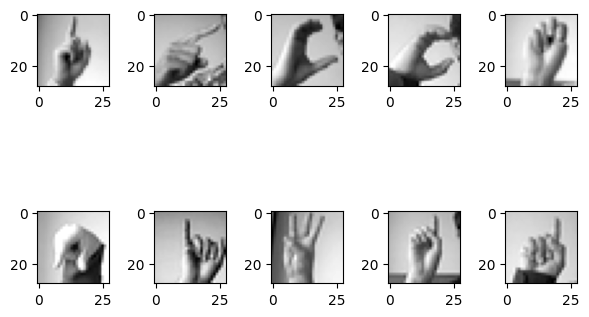

In [9]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(6, 6)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()   

In [10]:
# Making data augmentations to prevent overfitting
train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    validation_split=0.2)  

train_generator = train_datagen.flow(x_train, y_train, batch_size=256, subset='training')
validation_generator = train_datagen.flow(x_train, y_train, batch_size=256, subset='validation')

In [11]:
# Defining Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)
mcp_save = ModelCheckpoint("model.keras", save_best_only=True, monitor='val_loss')

In [12]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2 , padding='same'))

model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(128, (3,3), strides=1, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='valid'))
model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=24, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-04-13 19:44:35.669373: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-13 19:44:35.669409: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-13 19:44:35.669414: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-13 19:44:35.669451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-13 19:44:35.669463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

In [13]:
history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data=validation_generator,
                    callbacks=[learning_rate_reduction, early_stop, mcp_save])

Epoch 1/20


2024-04-13 19:44:36.188575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 4s 39ms/step - loss: 1.5387 - accuracy: 0.5559 - val_loss: 3.9364 - val_accuracy: 0.0581 - lr: 0.0010
Epoch 2/20
86/86 [==============================] - 3s 36ms/step - loss: 0.4860 - accuracy: 0.8441 - val_loss: 4.0287 - val_accuracy: 0.0738 - lr: 0.0010
Epoch 3/20
86/86 [==============================] - 3s 35ms/step - loss: 0.2603 - accuracy: 0.9193 - val_loss: 3.8811 - val_accuracy: 0.0570 - lr: 0.0010
Epoch 4/20
86/86 [==============================] - 3s 35ms/step - loss: 0.1677 - accuracy: 0.9478 - val_loss: 2.3457 - val_accuracy: 0.3635 - lr: 0.0010
Epoch 5/20
86/86 [==============================] - 3s 35ms/step - loss: 0.1222 - accuracy: 0.9607 - val_loss: 1.1378 - val_accuracy: 0.6560 - lr: 0.0010
Epoch 6/20
86/86 [==============================] - 3s 34ms/step - loss: 0.0941 - accuracy: 0.9715 - val_loss: 0.5410 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 7/20
86/86 [==============================] - 3s 35ms/step - loss: 0.0696 - accur

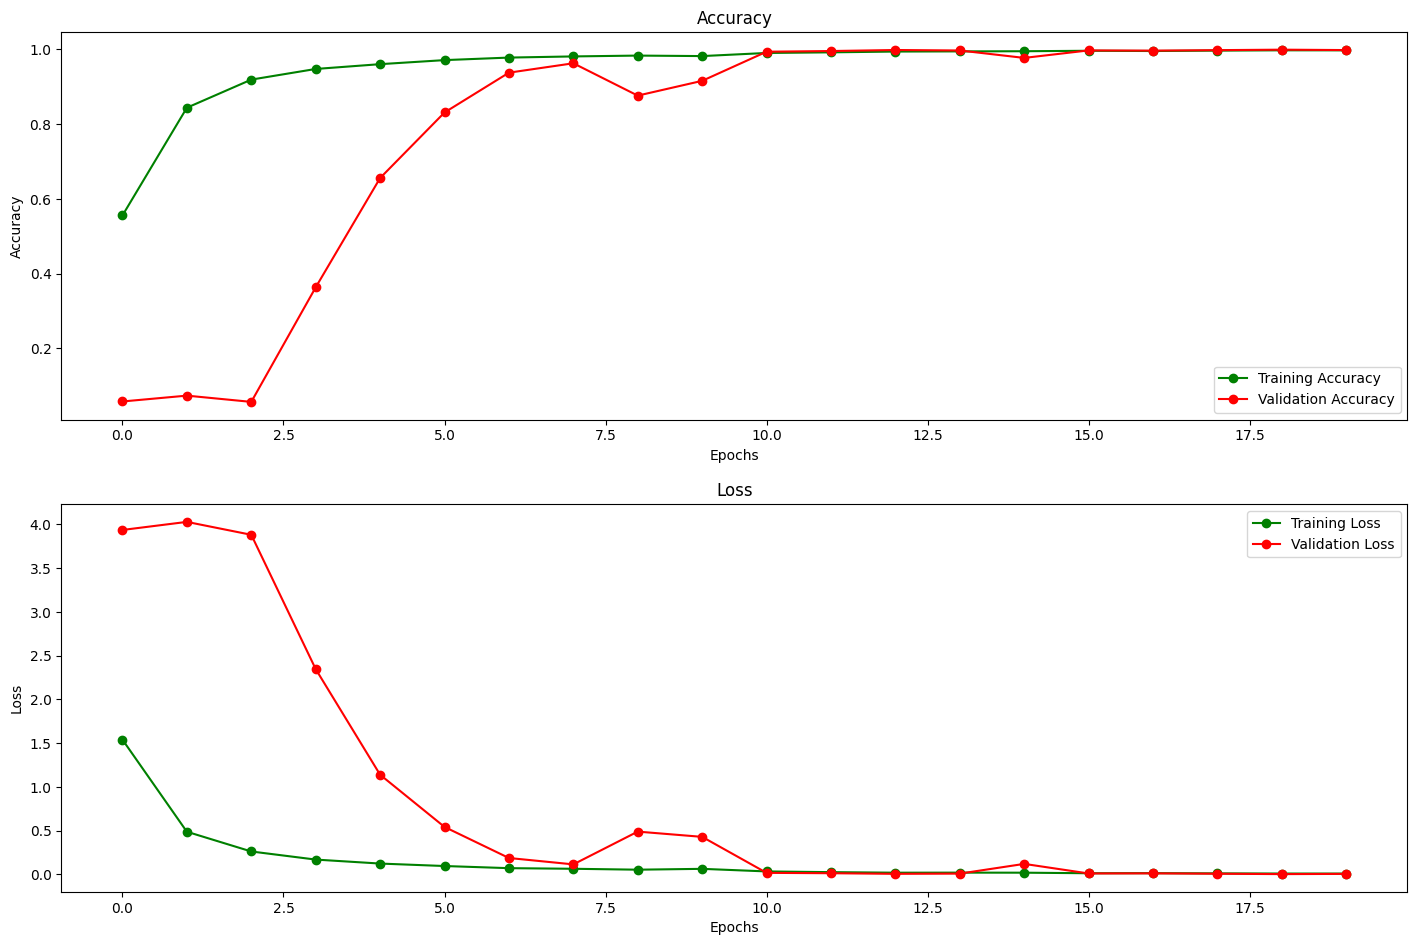

In [22]:
fig , ax = plt.subplots(2,1)
fig.set_size_inches(15, 10)
fig.tight_layout(pad=4)

epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax[1].plot(epochs, train_loss, 'g-o' ,label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o' ,label='Validation Loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [23]:
predictions = model.predict(x_test)
y_pred = predictions.argmax(axis=1)

for i in range(len(y_pred)):
    if(y_pred[i] >= 9):
        y_pred[i] += 1

classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y_test.to_numpy(), y_pred, target_names=classes))

225/225 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      0.99      0.99       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       0.99      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00   